In [112]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from utils import getfeature
from utils import parse_audio_files
import scipy
import numpy as np
import pandas as pd
import soundfile
from PIL import Image
import pathlib
import csv
from scipy import io
from scipy.io import wavfile
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import os
import glob

## Intro

Pour déterminer le genre de musique d'un morceau de musique, un certain nombre de variables basées sur le contenu sont d'abord extraites. En général, les fonctionnalités utilisées pour la classification de la musique peuvent être grossièrement classées en trois classes: la texture timbrale, les caractéristiques rythmiques et les caractéristiques de contenu de hauteur(pitch).

Les caractéristiques du timbre sont généralement caractérisées par les propriétés liées aux instrumentations ou aux sources sonores telles que la musique, la parole ou les signaux d'environnement. Les variables utilisées pour représenter la texture timbrale d'une piste musicale comprennent le zero crossing(le nombre de fois qu'un signal à traversé la barre horizontale à zéro), le centroïde spectral, le flux spectral, spectral rolloff, les coefficients cepstraux de fréquence Mel (MFCCs), etc.

## Chapitre
0. Chargement des données
1. Exploration
2. Extraction des features
3. Data processing (red dim, stats desc)
4. Application de SVM
5. Résultats
6. Source of code (if copied)

## Construction de la base de données

In [84]:
# Extraction des labels et des noms de fichier puis les enregistrer dans un dictionnaire
genres = []
path_audios = []
dirs = '../data_in/*/*'
for i in glob.glob(dirs):
    if glob.glob(i)[0][-4:] == ".wav":
        path_audios.append(i,)
        genres.append([i][0].split("/")[3].split(".")[0])


## EDA 

In [85]:
sample = dict(zip(genres, path_audios))

In [89]:
import random
_, value = random.choice(list(sample.items()))
print(_)
ipd.Audio(value)

hiphop


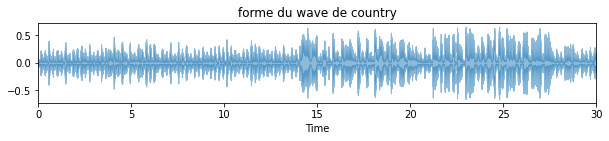

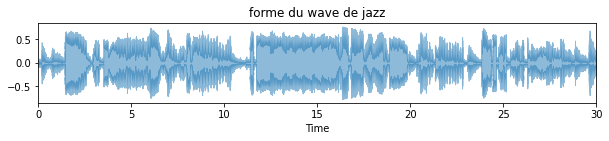

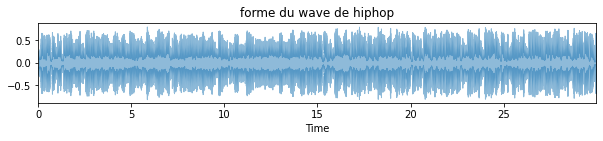

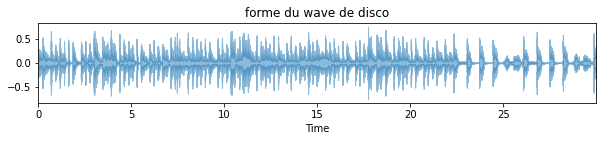

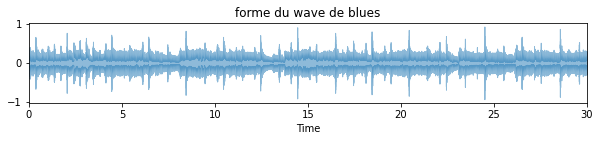

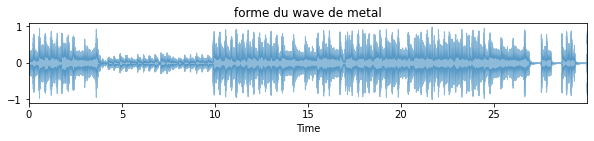

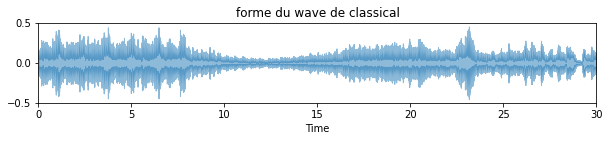

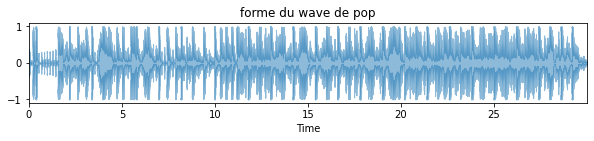

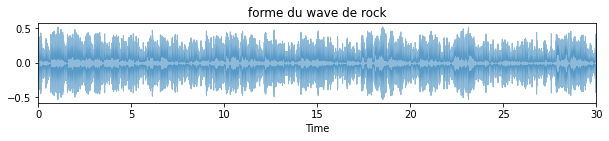

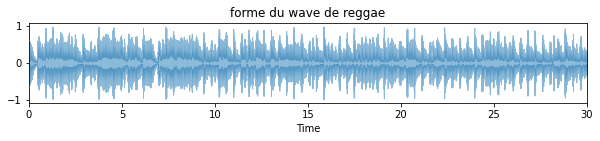

In [90]:
for genre, audio in sample.items():
    plt.figure(figsize=(10,5))
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(librosa.load(audio)[0], alpha=0.5)
    plt.title("forme du wave de "+genre)

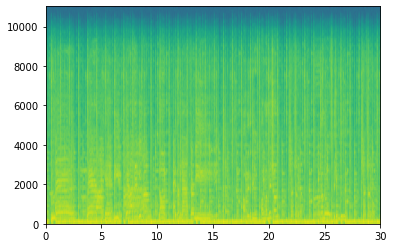

In [66]:
for label, audio in sample.items(): # a revoir
    sample_rate, X = wavfile.read(audio)
    spectro = specgram(X, Fs=sample_rate, xextent=(0,30))

In [ ]:
for label, audio in sample.items(): # a revoir
    sample_rate, X = wavfile.read(audio)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    spectral_centroids.shape

    (775,)# Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)# Normalising the spectral centroid for visualisation
    def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)#Plotting the Spectral Centroid along the waveform
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')

## [Features extraction](https://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_43_v2.pdf)
Chaque signal audio comprend de nombreuses variables. Cependant, nous devons extraire les variables qui sont pertinentes pour le problème que nous essayons de résoudre. Dans notre cas la reconnaissance du genre musicale.

initialement: zero_crossing, chroma freq, mfccs, rmse, amplitude envel, spectrale_centroid, spec rollof, 

In [65]:
# run, 
tr_features, tr_labels = parse_audio_files(musics)
# Concate feature et les labels
features = np.array(tr_features, dtype=pd.Series) 
labels_ = np.array(tr_labels, dtype=pd.Series)
run_df = pd.concat([pd.DataFrame(features), pd.DataFrame(labels_, columns=['labels'])], axis =1)
run_df.to_csv('../data_out/extrcated_feature.csv')
run_df.shape  # sanity check normalement 1000 lignes, 27 vars (13mfccs, 13chrma, 1zcr)

### Extraction nuérique à partir des spectro

In [103]:
file = open('../data_out/rawdata.csv', 'w', newline='')

# Les colonnes
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 14):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# initialisation du fichier 
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# Extraction des feature par boocle
for g in genres:
    for filename in os.listdir(f'../data_in/{g}'):
        songname = f'../data_in/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('../data_out/rawdata.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


In [105]:
raw_feature = pd.read_csv('../data_out/rawdata.csv')

In [106]:
raw_feature

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,label
0,blues.00093.wav,0.377607,570.040355,995.716054,927.651390,0.021697,-350.434662,169.539993,31.811310,16.683826,28.706919,19.251598,7.864568,10.033660,4.731571,2.913109,3.922059,1.825484,-5.968805,blues
1,blues.00026.wav,0.278378,1198.459085,1573.500275,2477.275946,0.051973,-284.848389,108.749542,9.129683,51.251312,18.123714,7.632778,8.775374,2.365382,0.019261,2.236927,4.190629,-3.304581,1.614048,blues
2,blues.00028.wav,0.276155,1115.728202,1399.096825,2290.646525,0.048020,-248.962250,139.031754,-16.240025,57.116192,20.192362,10.160373,4.576075,0.337924,-7.862825,-3.470246,-2.648825,-2.842670,-0.894775,blues
3,blues.00008.wav,0.408879,1719.368948,2031.740381,3782.316288,0.064025,-121.363945,122.506683,-14.738195,46.131065,-8.181879,20.182962,-19.173378,23.039139,-11.838223,21.159998,-6.718366,6.992541,-12.730597,blues
4,blues.00023.wav,0.280823,1209.987863,1497.691564,2521.741261,0.052467,-227.225342,137.788071,-14.499568,63.560928,5.617668,11.958148,1.907969,-1.889387,-7.604217,-2.473289,-2.891010,-9.433393,-10.929217,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00034.wav,0.421525,2788.250576,2648.300009,5831.991493,0.134925,-28.014147,65.664902,-7.318476,33.754230,11.125958,14.607217,2.095346,10.010471,-0.225996,10.134689,-2.854555,3.099469,-1.664787,rock
996,rock.00094.wav,0.389313,2628.863788,2210.478936,5085.874454,0.146649,-90.209846,80.066086,-46.360237,56.053726,-8.083482,27.479971,-17.327837,22.960869,-17.593615,18.408651,-17.429619,7.658797,-19.291197,rock
997,rock.00027.wav,0.402529,2669.225602,2440.309176,5445.858736,0.133422,-123.329430,74.883324,-17.064665,31.612310,2.544017,17.330688,-3.812694,9.729454,-7.234512,11.266804,0.379872,3.473368,1.668363,rock
998,rock.00051.wav,0.368741,3031.033547,3055.515508,6732.673210,0.120858,-66.252960,66.774910,25.188461,26.302618,5.295063,10.453684,2.464765,0.748177,-0.372901,1.727808,3.217985,5.040107,-1.938059,rock
